In [3]:
import xarray as xr
import pandas as pd
import numpy as np
import netCDF4 as ncf

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs # for projection
import cartopy.feature as cfeature # for map features 
from cartopy.util import add_cyclic_point

In [10]:
ds = xr.open_dataset('http://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/icec.mon.mean.nc', 
                     chunks={'time':'500MB'})

ds

<xarray.Dataset>
Dimensions:  (time: 511, lat: 720, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 1981-09-01 1981-10-01 ... 2024-03-01
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
Data variables:
    icec     (time, lat, lon) float32 dask.array<chunksize=(120, 720, 1440), meta=np.ndarray>
Attributes:
    Conventions:                     CF-1.5
    title:                           NOAA/NCEI 1/4 Degree Daily Optimum Inter...
    institution:                     NOAA/National Centers for Environmental ...
    source:                          NOAA/NCEI https://www.ncei.noaa.gov/data...
    References:                      https://www.psl.noaa.gov/data/gridded/da...
    dataset_title:                   NOAA Daily Optimum Interpolation Sea Sur...
    version:                         Version 2.1
    comment:                         Reynolds, et al.(2007) Daily High-Resolu...
    _NCProperties:                   version=2,netcdf=4.7.0,hdf5=1.10.5,
    DODS_EXTRA.Unlimited_Dimension:  time

In [16]:
ds = ds.sel(lat=slice(66,90),lon=slice(0,360),time=slice('1982-01-01', '2023-12-01'))
ds.time

<xarray.DataArray 'time' (time: 504)>
array(['1982-01-01T00:00:00.000000000', '1982-02-01T00:00:00.000000000',
       '1982-03-01T00:00:00.000000000', ..., '2023-10-01T00:00:00.000000000',
       '2023-11-01T00:00:00.000000000', '2023-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1982-01-01 1982-02-01 ... 2023-12-01
Attributes:
    long_name:     Time
    delta_t:       0000-01-00 00:00:00
    avg_period:    0000-01-00 00:00:00
    axis:          T
    actual_range:  [66352. 81874.]
    _ChunkSizes:   512

In [19]:
ds.to_netcdf('icec_data.nc', format='NETCDF3_64BIT')

In [4]:
ds = xr.open_dataset('icec_data.nc', decode_times=True)

In [5]:
icec = ds['icec']

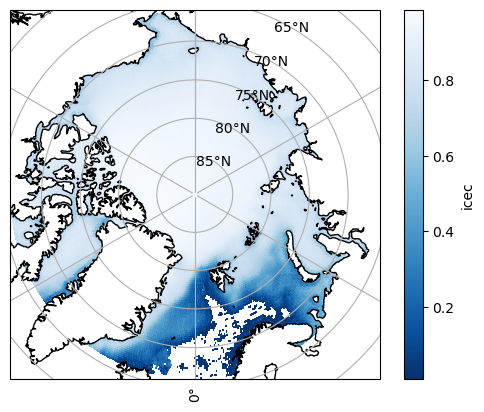

In [6]:
proj = ccrs.NorthPolarStereo()
trans = ccrs.PlateCarree()

fig, ax = plt.subplots(subplot_kw=dict(projection=proj))

# Gridlines
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

ax.coastlines()

time_avg_icec = ds['icec'].mean(dim='time')
time_avg_icec.plot(subplot_kws=dict(projection=proj),transform=trans,cmap='Blues_r')

In [7]:
lon = ds['lon']
lat = ds['lat']
icec_ltmean = ds['icec'].mean(dim='time')

# Create your meshgrid using lon and lat
X, Y = np.meshgrid(lon, lat)

In [8]:
#Deseasonalize data and compute anomalies
clm_icec = icec.groupby('time.month').mean(dim='time', skipna='True')
anm_icec = (icec.groupby('time.month') - clm_icec)

In [9]:
#Standardize data
icec_SD = anm_icec/anm_icec.std(dim='time')

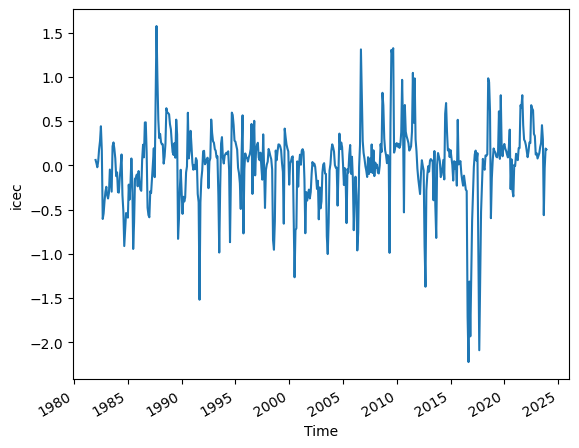

In [10]:
#Plot timeseries to see if there is a long term trend
icec_SD.mean(dim=['lat', 'lon']).plot()

No significant trend over time so detrending step unneccessary.

In [11]:
#Perform EOF analysis with cos lat weighting
from eofs.xarray import Eof

coslat = np.cos(np.deg2rad(icec_SD.coords['lat'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(icec_SD, weights=wgts)

In [12]:
eof1 = solver.eofsAsCorrelation(neofs=6) #calculate the first 6 EOFs

Text(0.5, 1.0, 'EOF6 expressed as correlation')

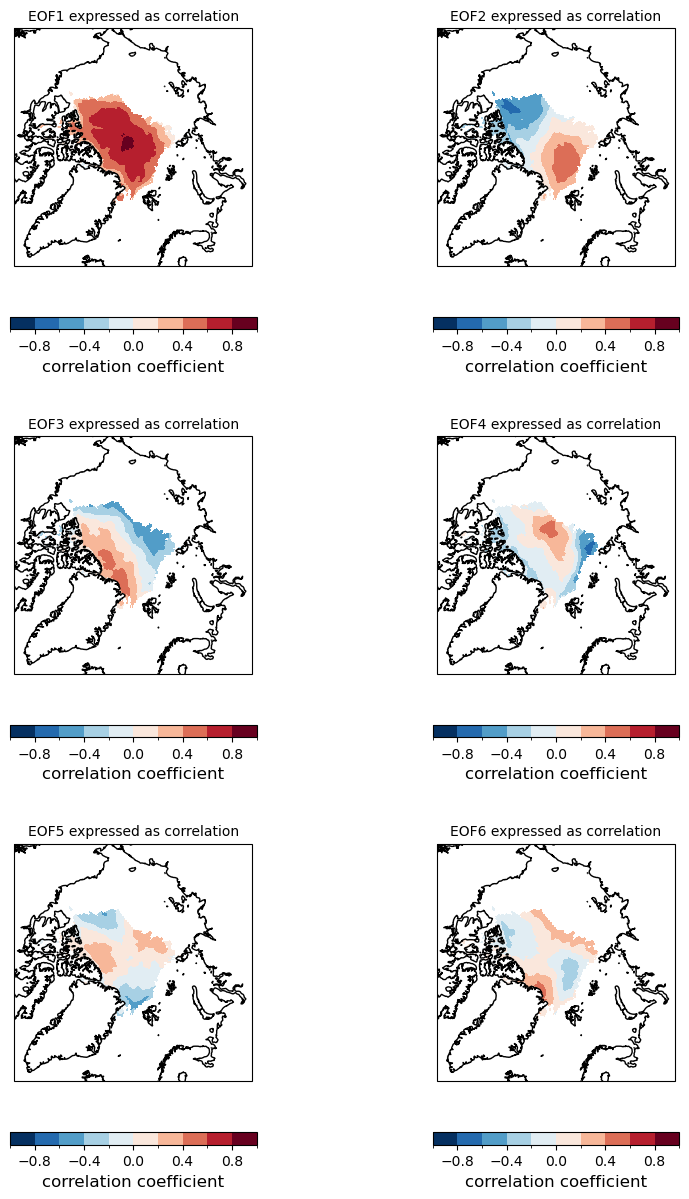

In [13]:
# Plot first 5 EOFs as correlation
fig, ax = plt.subplots(3,2,figsize=(10,15),subplot_kw=dict(projection=proj))

clevs = np.linspace(-1, 1, 11)

fill = eof1[0].plot.contourf(ax=ax[0,0], levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax[0,0].add_feature(cfeature.COASTLINE, edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal', shrink=0.7)
cb.set_label('correlation coefficient', fontsize=12)
ax[0,0].set_title('EOF1 expressed as correlation', fontsize=10)

fill = eof1[1].plot.contourf(ax=ax[0,1], levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax[0,1].add_feature(cfeature.COASTLINE, edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal', shrink=0.7)
cb.set_label('correlation coefficient', fontsize=12)
ax[0,1].set_title('EOF2 expressed as correlation', fontsize=10)

fill = eof1[2].plot.contourf(ax=ax[1,0], levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax[1,0].add_feature(cfeature.COASTLINE, edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal', shrink=0.7)
cb.set_label('correlation coefficient', fontsize=12)
ax[1,0].set_title('EOF3 expressed as correlation', fontsize=10)

fill = eof1[3].plot.contourf(ax=ax[1,1], levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax[1,1].add_feature(cfeature.COASTLINE, edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal', shrink=0.7)
cb.set_label('correlation coefficient', fontsize=12)
ax[1,1].set_title('EOF4 expressed as correlation', fontsize=10)

fill = eof1[4].plot.contourf(ax=ax[2,0], levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax[2,0].add_feature(cfeature.COASTLINE, edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal', shrink=0.7)
cb.set_label('correlation coefficient', fontsize=12)
ax[2,0].set_title('EOF5 expressed as correlation', fontsize=10)

fill = eof1[5].plot.contourf(ax=ax[2,1], levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax[2,1].add_feature(cfeature.COASTLINE, edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal', shrink=0.7)
cb.set_label('correlation coefficient', fontsize=12)
ax[2,1].set_title('EOF6 expressed as correlation', fontsize=10)

In [14]:
varfrac = solver.varianceFraction()

(2.8220581880594947e-15, 0.32532666087150575)

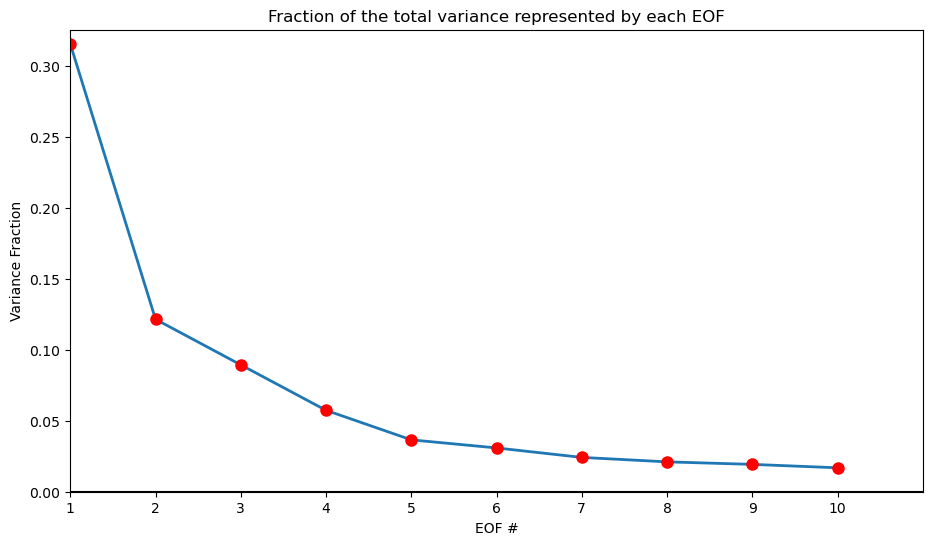

In [15]:
# Plot the fraction of variance explained by each the first 10 EOFs
plt.figure(figsize=(11,6))
eof_num = range(1, 11)
plt.plot(eof_num, varfrac[0:10], linewidth=2)
plt.plot(eof_num, varfrac[0:10], linestyle='None', marker="o", color='r', markersize=8)
plt.axhline(0, color='k')
plt.xticks(range(1, 11))
plt.title('Fraction of the total variance represented by each EOF')
plt.xlabel('EOF #')
plt.ylabel('Variance Fraction')
plt.xlim(1, 11)
plt.ylim(np.min(varfrac), np.max(varfrac)+0.01)

In [16]:
reconstruction = solver.reconstructedField(6) #reconstruct SST field using first 5 EOFs

In [17]:
correlation = xr.corr(icec_SD, reconstruction, dim='time') #calculate the correlation coefficient between reconstructed field

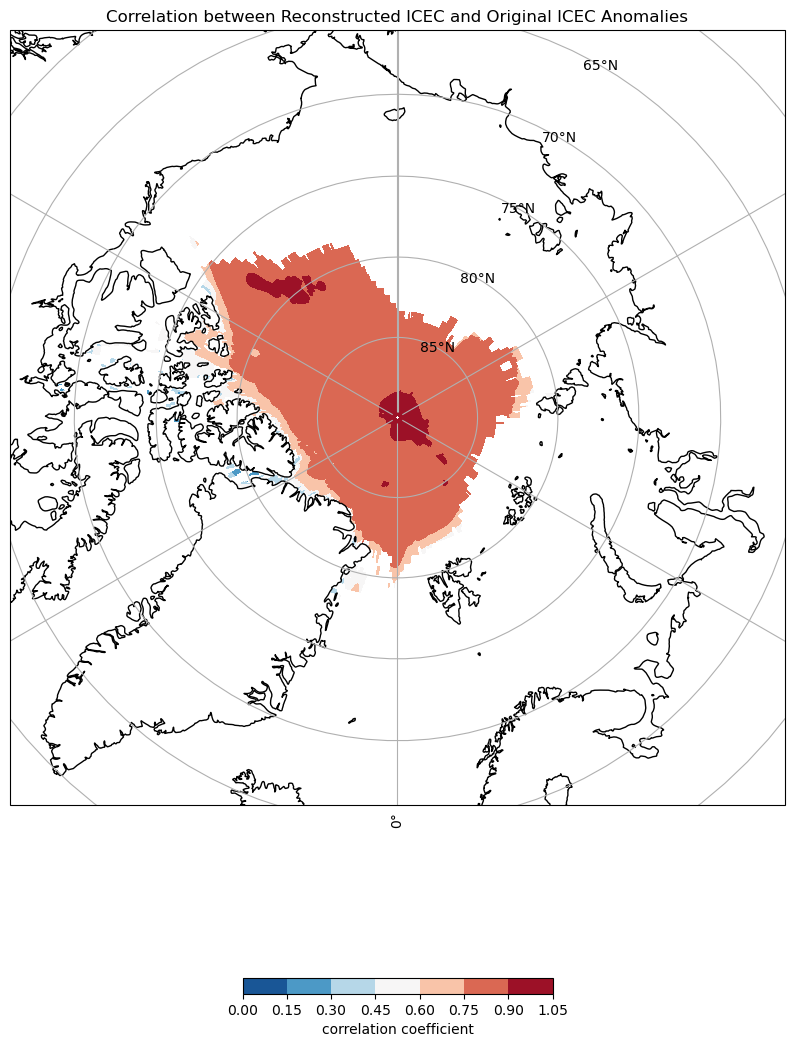

In [18]:
fig, ax = plt.subplots(figsize=(10,15),subplot_kw=dict(projection=proj))

gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree())
gl.top_labels = False
gl.right_labels = False

ax.coastlines()
ax.set_title('Correlation between Reconstructed ICEC and Original ICEC Anomalies')
#ax.set_extent((120, 300, -65, 65), crs=ccrs.PlateCarree())

cs = ax.contourf(X, Y, correlation, transform=ccrs.PlateCarree(), cmap=plt.cm.RdBu_r)
cb=fig.colorbar(cs, orientation='horizontal', shrink=0.4)

cb.set_label("correlation coefficient")


In [19]:
spavg_icec = icec_SD.mean(dim=['lat', 'lon'])
spavg_icec.shape

(504,)

In [20]:
columns = ['year', 'month', 'NAO Index']
nao = pd.read_csv('https://www.cpc.ncep.noaa.gov/products/precip/CWlink/pna/norm.nao.monthly.b5001.current.ascii', 
                  header=None, names=columns, delim_whitespace=True)
nao

,year,month,NAO Index
0,1950,1,0.9200
1,1950,2,0.4000
2,1950,3,-0.3600
3,1950,4,0.7300
4,1950,5,-0.5900
...,...,...,...
886,2023,11,-0.3194
887,2023,12,1.9365
888,2024,1,0.2060
889,2024,2,1.0894


In [21]:
nao['year'] = pd.to_datetime(nao['year'], format= '%Y')
nao = nao.set_index('year')
nao

,month,NAO Index
year,,
1950-01-01,1,0.9200
1950-01-01,2,0.4000
1950-01-01,3,-0.3600
1950-01-01,4,0.7300
1950-01-01,5,-0.5900
...,...,...
2023-01-01,11,-0.3194
2023-01-01,12,1.9365
2024-01-01,1,0.2060


In [22]:
nao = nao['1982': '2023']
nao

,month,NAO Index
year,,
1982-01-01,1,-0.8900
1982-01-01,2,1.1500
1982-01-01,3,1.1500
1982-01-01,4,0.1000
1982-01-01,5,-0.5300
...,...,...
2023-01-01,8,-1.1640
2023-01-01,9,-0.4408
2023-01-01,10,-2.0292


In [23]:
nao_ds = nao.to_xarray()

In [25]:
icec_SD

<xarray.DataArray 'icec' (time: 504, lat: 96, lon: 1440)>
array([[[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        ...,
        [-2.2989646e-01, -2.3175028e-01, -2.3309590e-01, ...,
         -2.3127304e-01, -2.3100106e-01, -2.2851978e-01],
        [-1.7324498e-01, -1.7440100e-01, -1.7260942e-01, ...,
         -1.7446235e-01, -1.7449374e-01, -1.7415453e-01],
        [-1.8209222e-01, -1.8139197e-01, -1.8033257e-01, ...,
         -1.8351769e-01, -1.8351080e-01, -1.8304551e-01]],

       [[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
...
        [ 4.9983931e-01,  5.0050247e-01,  5.0012141e-01, ...,
          5.2910173e-01,  5.2920812e-01,  4.9449915e-01],
        [ 1.0702870e-01,  1.1808193e-01,  1.1810146e-01, ...,
          1.8065028e-01,  1.5274221e-01,  1.2465219e-01],
        [-2.0906022e-01, -2.0904499e-01, -1.3205445e-01, ...,
         -7.5766042e-02, -1.3251013e-01, -1.3250366e-01]],

       [[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        ...,
        [ 2.1215750e-01,  2.1115270e-01,  2.3921162e-01, ...,
          3.1893110e-01,  3.1886023e-01,  2.4817234e-01],
        [-4.2735610e-02, -5.2567519e-02, -2.5283504e-02, ...,
          1.9494595e-02,  2.1316024e-02, -2.4366532e-02],
        [-1.6931565e-01, -1.6955893e-01, -1.3279504e-01, ...,
         -1.3323785e-01, -1.3323285e-01, -1.3299729e-01]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1982-01-01 1982-02-01 ... 2023-12-01
  * lat      (lat) float32 66.12 66.38 66.62 66.88 ... 89.12 89.38 89.62 89.88
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [29]:
new_ds = xr.merge([icec_SD,nao_ds['NAO Index']], compat='override')
new_ds

<xarray.Dataset>
Dimensions:    (time: 504, lat: 96, lon: 1440, year: 504)
Coordinates:
  * time       (time) datetime64[ns] 1982-01-01 1982-02-01 ... 2023-12-01
  * lat        (lat) float32 66.12 66.38 66.62 66.88 ... 89.12 89.38 89.62 89.88
  * lon        (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
    month      (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
  * year       (year) datetime64[ns] 1982-01-01 1982-01-01 ... 2023-01-01
Data variables:
    icec       (time, lat, lon) float32 nan nan nan ... -0.1332 -0.1332 -0.133
    NAO Index  (year) float64 -0.89 1.15 1.15 0.1 ... -2.029 -0.3194 1.937

In [1]:
ice_nao = xr.corr(spavg_icec, nao_ds['NAO Index'])
print(ice_nao)

NameError: name 'xr' is not defined